In [1]:
from math import sqrt
from sklearn.metrics import mean_squared_error

In [2]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np
from pandas import read_csv
# get market info for bitcoin from the start of 2014 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20131227&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info.head()
# load dataset
#bitcoin_market_info = read_csv('bitcoin_data.csv', header=0, index_col=0)

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-29,9346.41,9531.49,9193.71,9419.08,8853000000,158928000000
1,2018-04-28,8939.27,9412.09,8931.99,9348.48,7805480000,151991000000
2,2018-04-27,9290.63,9375.47,8987.05,8987.05,7566290000,157948000000
3,2018-04-26,8867.32,9281.51,8727.09,9281.51,8970560000,150736000000
4,2018-04-25,9701.03,9745.32,8799.84,8845.74,11083100000,164893000000


In [3]:
model_data = bitcoin_market_info[['Date','Open','High','Low','Close','Volume']]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,Open,High,Low,Close,Volume
1584,2013-12-27,763.28,777.51,713.60,735.07,46862700
1583,2013-12-28,737.98,747.06,705.35,727.83,32505800
1582,2013-12-29,728.05,748.61,714.44,745.05,19011300
1581,2013-12-30,741.35,766.60,740.24,756.13,20707700
1580,2013-12-31,760.32,760.58,738.17,754.01,20897300


In [4]:
model_data = bitcoin_market_info.sort_values(by='Date')
model_data.head()
start_date = '2013-12-29'
end_date = '2018-4-01'
model_data = model_data[model_data['Date']>=start_date]
model_data = model_data[model_data['Date']<=end_date]
model_data2 = model_data
model_data = model_data.drop('Date', 1)


In [5]:
split = int(len(model_data)/10)
training_set, test_set = model_data[0:split*9], model_data[split:]


In [6]:
window_len = 10
norm_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

In [7]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [8]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

/Users/junyi_chen/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [9]:
model = build_model(LSTM_training_inputs, output_size=1, neurons = 15)

In [10]:
predict_len=1

In [11]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len-predict_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len+predict_len:].values/test_set['Close'][:-window_len-predict_len].values)-1

In [12]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [13]:
LSTM_training_inputs.shape

(1385, 10, 6)

In [14]:
history = model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=70, batch_size=1, verbose=2, shuffle=True, validation_data = (LSTM_test_inputs,LSTM_test_outputs))

Train on 1385 samples, validate on 1389 samples
Epoch 1/70
 - 11s - loss: 0.0533 - val_loss: 0.0513
Epoch 2/70
 - 11s - loss: 0.0382 - val_loss: 0.0433
Epoch 3/70
 - 11s - loss: 0.0341 - val_loss: 0.0407
Epoch 4/70
 - 11s - loss: 0.0313 - val_loss: 0.0410
Epoch 5/70
 - 11s - loss: 0.0306 - val_loss: 0.0395
Epoch 6/70
 - 12s - loss: 0.0299 - val_loss: 0.0413
Epoch 7/70
 - 11s - loss: 0.0300 - val_loss: 0.0387
Epoch 8/70
 - 12s - loss: 0.0296 - val_loss: 0.0395
Epoch 9/70
 - 11s - loss: 0.0295 - val_loss: 0.0387
Epoch 10/70
 - 11s - loss: 0.0286 - val_loss: 0.0393
Epoch 11/70
 - 11s - loss: 0.0283 - val_loss: 0.0386
Epoch 12/70
 - 11s - loss: 0.0279 - val_loss: 0.0388
Epoch 13/70
 - 12s - loss: 0.0281 - val_loss: 0.0385
Epoch 14/70
 - 12s - loss: 0.0284 - val_loss: 0.0384
Epoch 15/70
 - 11s - loss: 0.0281 - val_loss: 0.0395
Epoch 16/70
 - 11s - loss: 0.0281 - val_loss: 0.0384
Epoch 17/70
 - 12s - loss: 0.0282 - val_loss: 0.0402
Epoch 18/70
 - 11s - loss: 0.0272 - val_loss: 0.0394
Epoch 1

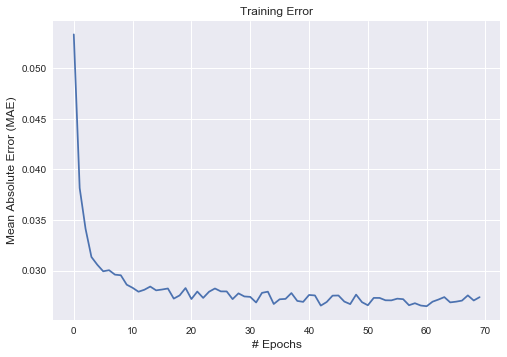

In [15]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(history.epoch, history.history['loss'])
ax1.set_title('Training Error')

if model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

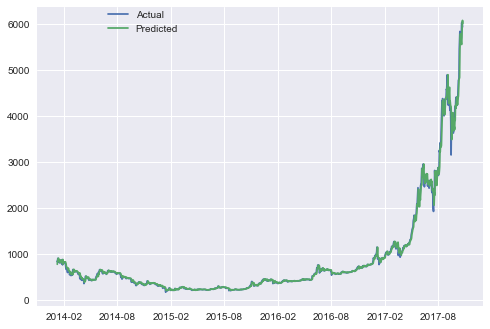

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
plt.close()
y1=training_set['Close'][window_len:]
y2=((np.transpose(model.predict(LSTM_training_inputs))+1) * training_set['Close'].values[:-window_len])[0]
plt.plot(model_data2['Date'][window_len:split*9].astype(datetime.datetime),
         y1,label='Actual')
plt.plot(model_data2['Date'][window_len+1:split*9+1].astype(datetime.datetime),y2, 
         label='Predicted')
plt.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 10})
plt.show()

In [18]:
rmse = sqrt(mean_squared_error(y1, y2))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 60.333
